In [1]:
import tensorflow as tf
import keras
import retina
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics

In [20]:
df = pd.read_csv(retina.filesys.TRAINING_DATA_CSV_PATH, index_col=False)
labels = df["label"]
df = df.drop(columns=["label"])
df

,feature-1,feature-2,feature-3,feature-4,feature-5,feature-6,feature-7,feature-8,feature-9,feature-10,...,feature-375,feature-376,feature-377,feature-378,feature-379,feature-380,feature-381,feature-382,feature-383,feature-384
0,0.004167,0.004097,0.003403,0.000972,0.000417,0.002569,0.006389,0.000208,0.001806,0.000347,...,0.001458,0.000208,0.000417,0.000278,0.006042,0.001111,0.001111,0.001389,0.002014,0.003958
1,0.004097,0.000625,0.000833,0.002500,0.001597,0.005972,0.006181,0.001944,0.001875,0.000903,...,0.000486,0.000417,0.000417,0.001319,0.010347,0.001389,0.000764,0.002153,0.000208,0.000764
2,0.009444,0.004306,0.001250,0.000069,0.000069,0.000486,0.007708,0.003611,0.000417,0.000347,...,0.000764,0.000000,0.000208,0.000208,0.008125,0.004583,0.001597,0.000208,0.000069,0.001042
3,0.009444,0.001111,0.001042,0.000556,0.000694,0.002778,0.006597,0.001597,0.000903,0.002778,...,0.001042,0.002222,0.000556,0.000278,0.003542,0.002222,0.004167,0.002569,0.001389,0.001736
4,0.001944,0.000347,0.000000,0.004306,0.009028,0.000000,0.008056,0.002153,0.000764,0.002083,...,0.002500,0.000000,0.003542,0.006111,0.003333,0.001736,0.003750,0.000694,0.004167,0.001944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7173,0.004722,0.003889,0.002986,0.001736,0.000833,0.001458,0.008264,0.001181,0.001181,0.001389,...,0.000278,0.005556,0.003542,0.001944,0.002153,0.000694,0.002986,0.000556,0.001597,0.007639
7174,0.008958,0.000556,0.001181,0.000625,0.000556,0.003750,0.008681,0.000347,0.000417,0.000347,...,0.001250,0.000833,0.001042,0.002847,0.006250,0.003264,0.003056,0.001181,0.000347,0.001528
7175,0.005833,0.000139,0.001111,0.000139,0.000764,0.007639,0.005000,0.000139,0.001042,0.001389,...,0.001597,0.000208,0.001319,0.000278,0.003889,0.004167,0.000972,0.000833,0.003889,0.001875
7176,0.002847,0.003194,0.002778,0.000208,0.002361,0.004236,0.004375,0.000903,0.000556,0.000417,...,0.003472,0.000278,0.000278,0.002569,0.003125,0.002569,0.000486,0.001667,0.004653,0.003125


In [21]:
dataset = tf.data.Dataset.from_tensor_slices((df, labels))
train_dataset, test_dataset = keras.utils.split_dataset(dataset, shuffle=True, seed=42, left_size=0.7)
train_dataset, validation_dataset = keras.utils.split_dataset(train_dataset, shuffle=True, seed=42, left_size=0.7)

train_dataset: tf.data.Dataset = train_dataset.shuffle(100).batch(16)
test_dataset: tf.data.Dataset = test_dataset.batch(16)
validation_dataset: tf.data.Dataset = validation_dataset.batch(16)

dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(384,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>

In [23]:
model = keras.Sequential([
  keras.layers.Input(shape=dataset.element_spec[0].shape),
  keras.layers.Dense(512, activation="relu"),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(256, activation="relu"),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(64, activation="relu"),
  keras.layers.Dense(7, activation="softmax"),
])

model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001), # type: ignore
  loss=keras.losses.SparseCategoricalCrossentropy(),
  metrics=["accuracy"],
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,943 (906.03 KB)

 Trainable params: 231,943 (906.03 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history = model.fit(
  train_dataset, epochs=15,
  validation_data=validation_dataset,
)

Epoch 1/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5534 - loss: 1.1698 - val_accuracy: 0.4167 - val_loss: 1.6692
Epoch 2/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5369 - loss: 1.1675 - val_accuracy: 0.4081 - val_loss: 1.7326
Epoch 3/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5480 - loss: 1.1527 - val_accuracy: 0.4141 - val_loss: 1.6535
Epoch 4/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5553 - loss: 1.1416 - val_accuracy: 0.4161 - val_loss: 1.6150
Epoch 5/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5514 - loss: 1.1489 - val_accuracy: 0.4214 - val_loss: 1.6693
Epoch 6/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5834 - loss: 1.0976 - val_accuracy: 0.4141 - val_loss: 1.6676
Epoch 7/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5651 - loss: 1.1288 - val_accuracy: 0.4081 - val_loss: 1.6520
Epoch 8/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5610 - loss: 1.1308 - val_accuracy: 0.

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


C:\Users\Davin Tristan\AppData\Local\Temp\ipykernel_9388\2111063400.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
d:\Davin\College\Semester7-DeepLearning\Venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Davin\College\Semester7-DeepLearning\Venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Davin\College\Semester7-DeepLearning\Venv\Lib\site-packag

{'angry': {'precision': 0.3216374269005848,
  'recall': 0.1858108108108108,
  'f1-score': 0.23554603854389722,
  'support': 296.0},
 'disgust': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 30.0},
 'fear': {'precision': 0.2066115702479339,
  'recall': 0.08250825082508251,
  'f1-score': 0.1179245283018868,
  'support': 303.0},
 'happy': {'precision': 0.556,
  'recall': 0.7595628415300546,
  'f1-score': 0.6420323325635104,
  'support': 549.0},
 'neutral': {'precision': 0.36829268292682926,
  'recall': 0.4136986301369863,
  'f1-score': 0.3896774193548387,
  'support': 365.0},
 'sad': {'precision': 0.2577565632458234,
  'recall': 0.28346456692913385,
  'f1-score': 0.27,
  'support': 381.0},
 'surprise': {'precision': 0.5177304964539007,
  'recall': 0.6375545851528385,
  'f1-score': 0.5714285714285714,
  'support': 229.0},
 'accuracy': 0.41895030190431953,
 'macro avg': {'precision': 0.3182898199678675,
  'recall': 0.33751424076927233,
  'f1-score': 0.3180869843132435,

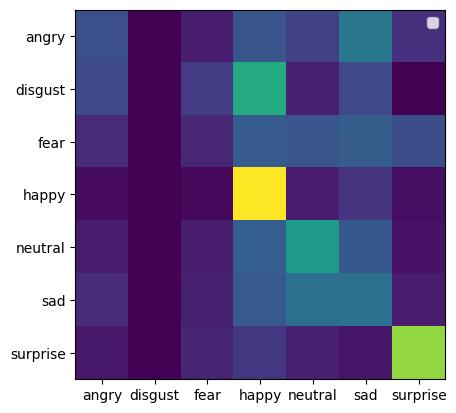

In [11]:
from typing import cast

confidences = model.predict(test_dataset)
predictions = np.argmax(confidences, axis=1)

labels = cast(list[int], list(test_dataset.unbatch().map(lambda x, y: y).as_numpy_iterator()))
target_names = retina.face.FacialExpressionLabels.Fer2013

cmat = sklearn.metrics.confusion_matrix(labels, predictions, normalize="true")

plt.imshow(cmat)
plt.legend()
plt.xticks(range(len(target_names)), target_names)
plt.yticks(range(len(target_names)), target_names)

sklearn.metrics.classification_report(labels, predictions, output_dict=True, target_names=target_names)

In [35]:
model.save(retina.filesys.EXPRESSION_RECOGNITION_MODEL_PATH)

C:\Users\Davin Tristan\AppData\Local\Temp\ipykernel_9388\469801421.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  accuracy_fig.show()


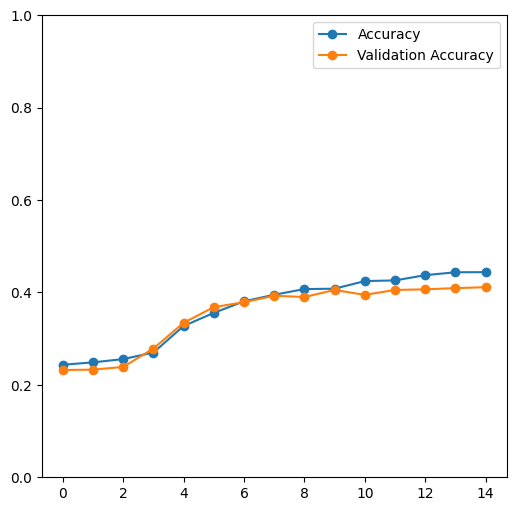

In [12]:
accuracy_fig = plt.figure(figsize=(6,6))
ax = accuracy_fig.add_subplot()
ax.plot(history.history["accuracy"], label="Accuracy", marker='o')
ax.plot(history.history["val_accuracy"], label="Validation Accuracy", marker='o')
ax.legend()
ax.set_ylim(0, 1)
accuracy_fig.show()